In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../datasets/ecommerceDataset.csv', names = ['target', 'feature'])
df.head(3)

,target,feature
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...


In [2]:
df.dropna(inplace=True)

In [3]:
df.shape

(50424, 2)

# Now we preprocess the data.

- convert_to_lowercase:  converts the text to lowercase 
- remove_whitespaces: removes unnecessary empty whitespaces from the text 
- remove_punctuations: removes punctuations but we keep the apostrophes 
- remove_html: removes html links from the text 
- remove_http: removes http links from the text 
- remove_stopwords: removing stop words since they have no impact on the classification procedure 
- text_stemmer: converting the words to their root form 
- discard_non_alpha: discarding non-alphabetic words because they create unnecessary diversions 

In [4]:

import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

regexp = RegexpTokenizer("[\w']+")

def convert_to_lowercase(text):
    return text.lower()
def remove_whitespace(text):
    return text.strip()
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)
# Stopwords
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha


# Integration process 

- We integrate the text normalization processes in appropriate order. We also converted the text into one line and removed square brackets.

In [5]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_stopwords(text)
    text = discard_non_alpha(text)
    return text

In [6]:
df['feature'] = df['feature'].apply(text_normalizer)


# Application of TF-IDF Vectorization

- Extracted a maximum of 15000 features.
- We've set the ngram_range to (1,2) to consider both unigrams (single words) and bigrams (two-word sequences) when creating the TF IDF matrix.
- We set smooth idf to True, meaning: $ \text{IDF}(t) = \log\left(\frac{N}{\text{df}(t)}\right) + 1 $. This ensures that document frequencies with a value of 0 don't resolve into an undefined or infinite IDF.
- We set sublinear_tf to True, meaning that we apply logarithmic transformation to the TF values when computing the TF-IDF weights to make them less sensitive to extremely high term frequencies. $ \text{TF}(t, d) = 1 + \log(\text{TF}(t, d)) $

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), max_features=15000, smooth_idf=True, sublinear_tf=True)
df_feature = vectorizer.fit_transform(df['feature'])

In [8]:
from sklearn.model_selection import train_test_split

df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_feature, df['target'], test_size=0.2, random_state=42)

# Applied Naive Bayes Classifier 

- used the MultinomialNB object for text classification

In [9]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(df_features_train, df_target_train)
df_target_prediction = nb_model.predict(df_features_test)

In [10]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(df_target_test, df_target_prediction))

                        precision    recall  f1-score   support

                 Books       0.97      0.91      0.94      2378
Clothing & Accessories       0.96      0.97      0.96      1750
           Electronics       0.94      0.93      0.93      2082
             Household       0.93      0.96      0.94      3875

              accuracy                           0.94     10085
             macro avg       0.95      0.94      0.95     10085
          weighted avg       0.95      0.94      0.94     10085



In [11]:
accuracy_score = accuracy_score(df_target_test, df_target_prediction)

In [12]:
accuracy_score

0.9445711452652454

array([[2167,   26,   36,  149],
       [   5, 1702,   11,   32],
       [  40,    6, 1928,  108],
       [  32,   44,   70, 3729]])

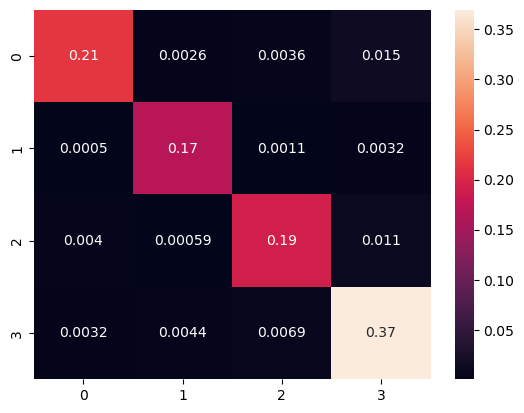

In [13]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(df_target_test, df_target_prediction)
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True)
cf_matrix